In [1]:
!pip install scikit-fuzzy pandas matplotlib scikit-learn seaborn shap gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import shap
import gradio as gr

## 1. Load and Prepare Data

In [3]:
from google.colab import files
print("Please upload your 'WA_Fn-UseC_-HR-Employee-Attrition.csv' file.")
uploaded = files.upload()

# Load the dataset
df = pd.read_csv(next(iter(uploaded)))
print("\nDataset Head:")
df.head()

Please upload your 'WA_Fn-UseC_-HR-Employee-Attrition.csv' file.


Saving archive (2).zip to archive (2).zip

Dataset Head:


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# Drop irrelevant columns for this analysis
df_processed = df.drop(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber'], axis=1, errors='ignore')

# Encode categorical columns
df_encoded = pd.get_dummies(df_processed, drop_first=True)

# Check nulls and basic info
print("Encoded DataFrame Info:")
df_encoded.info()

Encoded DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1470 non-null   int64
 1   DailyRate                          1470 non-null   int64
 2   DistanceFromHome                   1470 non-null   int64
 3   Education                          1470 non-null   int64
 4   EnvironmentSatisfaction            1470 non-null   int64
 5   HourlyRate                         1470 non-null   int64
 6   JobInvolvement                     1470 non-null   int64
 7   JobLevel                           1470 non-null   int64
 8   JobSatisfaction                    1470 non-null   int64
 9   MonthlyIncome                      1470 non-null   int64
 10  MonthlyRate                        1470 non-null   int64
 11  NumCompaniesWorked                 1470 non-null   int64
 

In [5]:
# Simulate 'AccessRisk' label based on conditions (using original df for clarity on JobLevel and MonthlyIncome)
def simulate_access_label(row):
    if row['JobLevel'] >= 4 and row['MonthlyIncome'] > 10000:
        return 'High'
    elif row['JobLevel'] >= 2 and row['MonthlyIncome'] > 5000:
        return 'Medium'
    else:
        return 'Low'

df['AccessRisk'] = df.apply(simulate_access_label, axis=1)
df_encoded['AccessRisk'] = df['AccessRisk'] # Add the simulated label to the encoded dataframe

print("\nSimulated AccessRisk distribution:")
print(df['AccessRisk'].value_counts())


Simulated AccessRisk distribution:
AccessRisk
Low       749
Medium    546
High      175
Name: count, dtype: int64


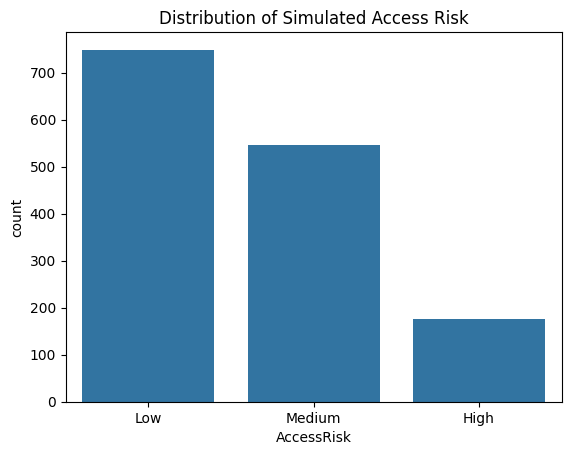

In [6]:
sns.countplot(data=df, x='AccessRisk', order=['Low', 'Medium', 'High'])
plt.title("Distribution of Simulated Access Risk")
plt.show()

## 2. Machine Learning Model for Access Risk Prediction

In [7]:
# Prepare data for ML model
# For a more realistic ML task, we drop features directly used in 'AccessRisk' simulation
X_ml = df_encoded.drop(['AccessRisk', 'JobLevel', 'MonthlyIncome'], axis=1, errors='ignore')
y_ml = df_encoded['AccessRisk'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.3, random_state=42, stratify=y_ml)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_ml = clf.predict(X_test)

print("Random Forest Model Performance:")
print(classification_report(y_test, y_pred_ml))
print(f"Accuracy: {accuracy_score(y_test, y_pred_ml):.2f}")

Random Forest Model Performance:
              precision    recall  f1-score   support

        High       0.87      0.79      0.83        52
         Low       0.92      0.87      0.89       225
      Medium       0.78      0.85      0.81       164

    accuracy                           0.85       441
   macro avg       0.86      0.84      0.85       441
weighted avg       0.86      0.85      0.86       441

Accuracy: 0.85


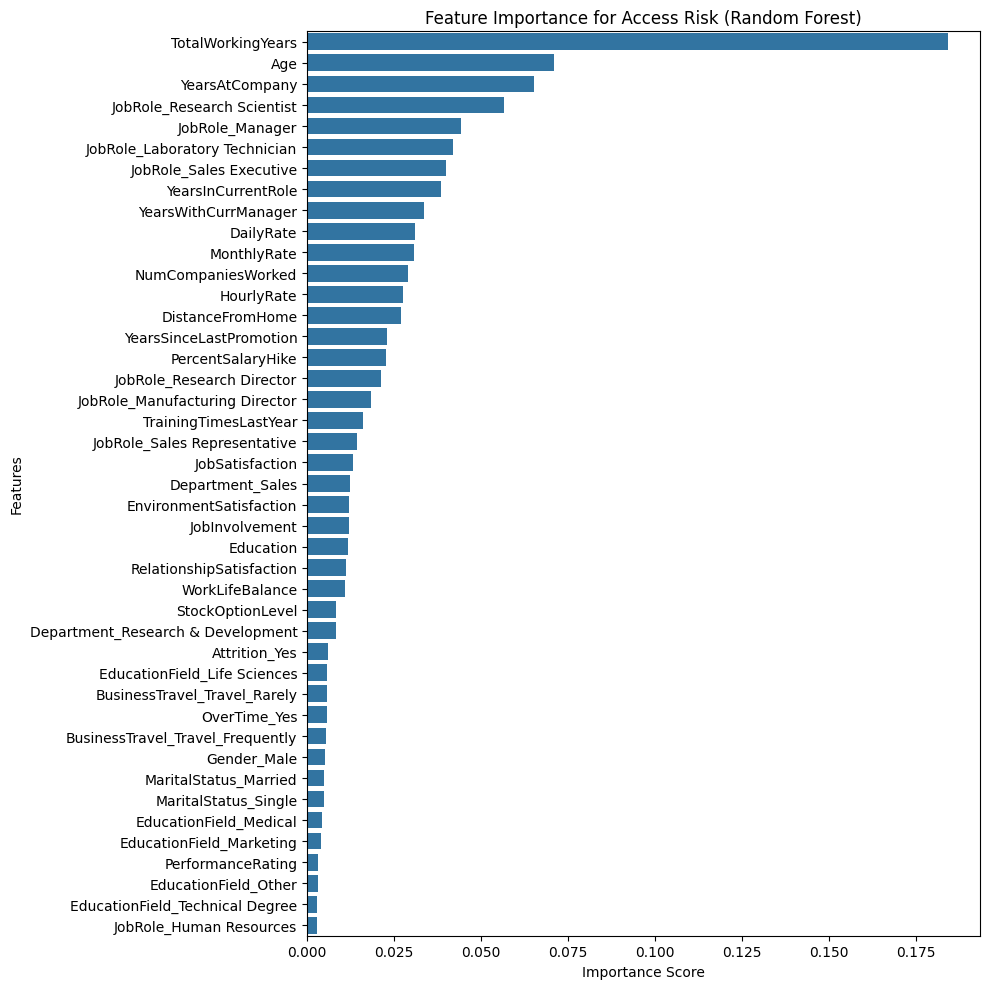

In [8]:
# Plot feature importances from RandomForest
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
plt.figure(figsize=(10, 10)) # Adjusted for potentially many features
sns.barplot(x=feature_importances.sort_values(ascending=False), y=feature_importances.sort_values(ascending=False).index)
plt.title('Feature Importance for Access Risk (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

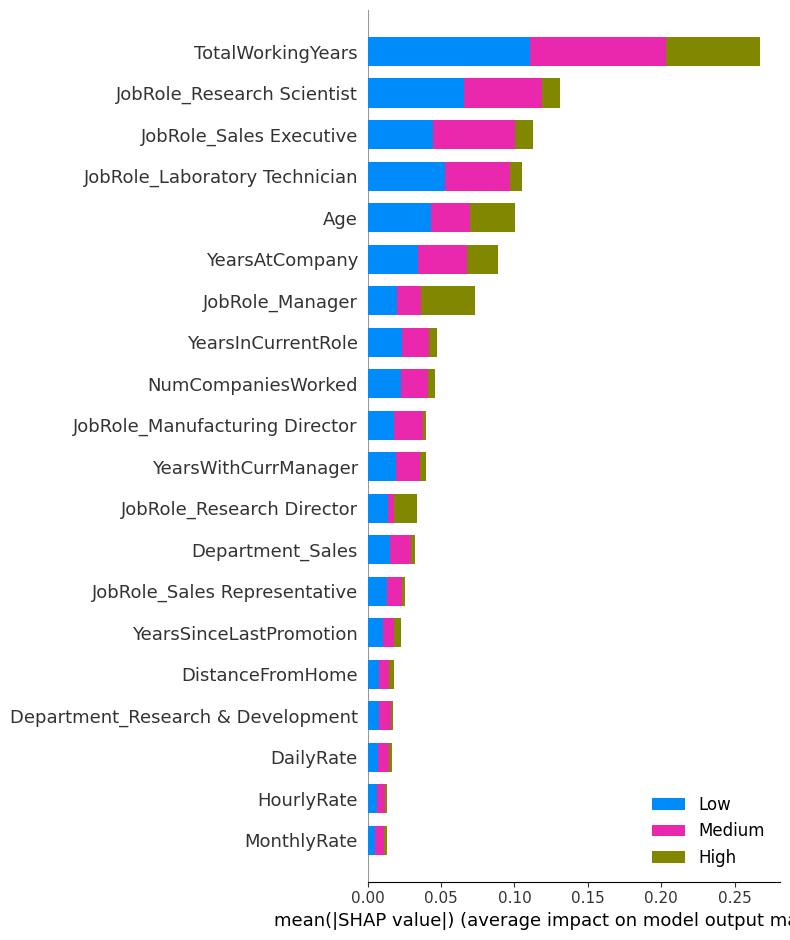

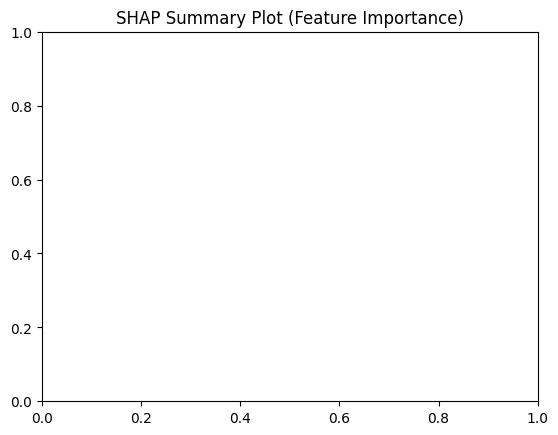

In [12]:
# SHAP Explainability for ML Predictions
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test) # Use the same X_test the model was evaluated on

# Summary plot (feature importance)
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=clf.classes_)
plt.title("SHAP Summary Plot (Feature Importance)")
plt.show()

## 3. Fuzzy Logic System for Access Risk

In [13]:
# Define fuzzy input variables
# Ranges for antecedents should ideally reflect your data or domain knowledge
age_fuzzy = ctrl.Antecedent(np.arange(18, 61, 1), 'Age')
# Using MonthlyIncome stats for a relevant range (ensure 'df' is your original dataframe)
income_fuzzy = ctrl.Antecedent(np.arange(df['MonthlyIncome'].min(), df['MonthlyIncome'].max() + 1, 100), 'Income')
job_level_fuzzy = ctrl.Antecedent(np.arange(1, 6, 1), 'JobLevel')

# Define fuzzy output variable
access_risk_fuzzy_output = ctrl.Consequent(np.arange(0, 101, 1), 'AccessRisk_Fuzzy')

# Membership functions for Age
age_fuzzy['young'] = fuzz.trimf(age_fuzzy.universe, [18, 25, 35])
age_fuzzy['middle'] = fuzz.trimf(age_fuzzy.universe, [30, 40, 50])
age_fuzzy['senior'] = fuzz.trimf(age_fuzzy.universe, [45, 55, 60])

# Membership functions for Income
income_fuzzy['low_income'] = fuzz.trimf(income_fuzzy.universe, [income_fuzzy.universe.min(), income_fuzzy.universe.min(), 7000])
income_fuzzy['medium_income'] = fuzz.trimf(income_fuzzy.universe, [5000, 10000, 15000])
income_fuzzy['high_income'] = fuzz.trimf(income_fuzzy.universe, [12000, income_fuzzy.universe.max(), income_fuzzy.universe.max()])

# Membership functions for JobLevel
job_level_fuzzy['low_level'] = fuzz.trimf(job_level_fuzzy.universe, [1, 1, 3])
job_level_fuzzy['medium_level'] = fuzz.trimf(job_level_fuzzy.universe, [2, 3, 4])
job_level_fuzzy['high_level'] = fuzz.trimf(job_level_fuzzy.universe, [3, 5, 5]) # Adjusted for high level

# Output fuzzy membership (matching Gradio logic for Low, Medium, High thresholds)
access_risk_fuzzy_output['low_risk'] = fuzz.trimf(access_risk_fuzzy_output.universe, [0, 15, 30])
access_risk_fuzzy_output['medium_risk'] = fuzz.trimf(access_risk_fuzzy_output.universe, [25, 50, 75]) # Centered around 50 for medium
access_risk_fuzzy_output['high_risk'] = fuzz.trimf(access_risk_fuzzy_output.universe, [70, 85, 100])

In [14]:
# Define fuzzy rules (These are examples and should be tailored to your IAM logic)
rule1_f = ctrl.Rule(job_level_fuzzy['low_level'] & income_fuzzy['low_income'], access_risk_fuzzy_output['low_risk'])
rule2_f = ctrl.Rule(job_level_fuzzy['high_level'] & income_fuzzy['high_income'], access_risk_fuzzy_output['high_risk'])
rule3_f = ctrl.Rule(age_fuzzy['young'] & income_fuzzy['low_income'] & job_level_fuzzy['low_level'], access_risk_fuzzy_output['low_risk'])
rule4_f = ctrl.Rule(age_fuzzy['senior'] & income_fuzzy['high_income'] & job_level_fuzzy['high_level'], access_risk_fuzzy_output['high_risk'])
rule5_f = ctrl.Rule(income_fuzzy['medium_income'] & job_level_fuzzy['medium_level'], access_risk_fuzzy_output['medium_risk'])
rule6_f = ctrl.Rule(age_fuzzy['middle'] & income_fuzzy['medium_income'], access_risk_fuzzy_output['medium_risk'])
rule7_f = ctrl.Rule(job_level_fuzzy['high_level'] & (age_fuzzy['middle'] | age_fuzzy['senior']), access_risk_fuzzy_output['high_risk'])
rule8_f = ctrl.Rule(age_fuzzy['young'] & job_level_fuzzy['medium_level'], access_risk_fuzzy_output['medium_risk'])
rule9_f = ctrl.Rule(income_fuzzy['low_income'], access_risk_fuzzy_output['low_risk'])
rule10_f = ctrl.Rule(job_level_fuzzy['high_level'], access_risk_fuzzy_output['high_risk'])

# Control system
access_risk_ctrl_fuzzy = ctrl.ControlSystem([rule1_f, rule2_f, rule3_f, rule4_f, rule5_f, rule6_f, rule7_f, rule8_f, rule9_f, rule10_f])
access_risk_sim_fuzzy = ctrl.ControlSystemSimulation(access_risk_ctrl_fuzzy)

Sample Fuzzy Access Risk Score: 15.00


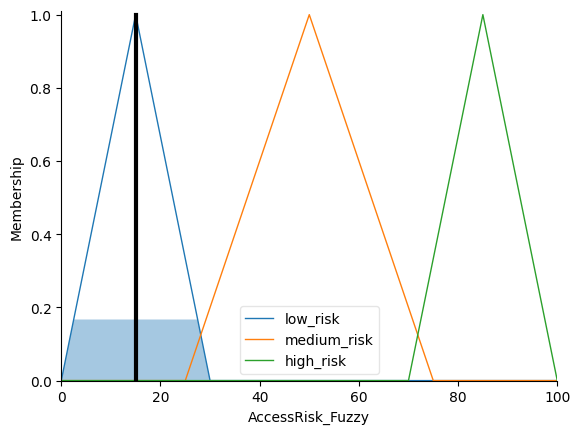

In [15]:
# Sample fuzzy logic prediction
access_risk_sim_fuzzy.input['Age'] = 30
access_risk_sim_fuzzy.input['Income'] = 6000
access_risk_sim_fuzzy.input['JobLevel'] = 2

access_risk_sim_fuzzy.compute()
print(f"Sample Fuzzy Access Risk Score: {access_risk_sim_fuzzy.output['AccessRisk_Fuzzy']:.2f}")
access_risk_fuzzy_output.view(sim=access_risk_sim_fuzzy)

## 4. Comparison of ML and Fuzzy Logic Predictions

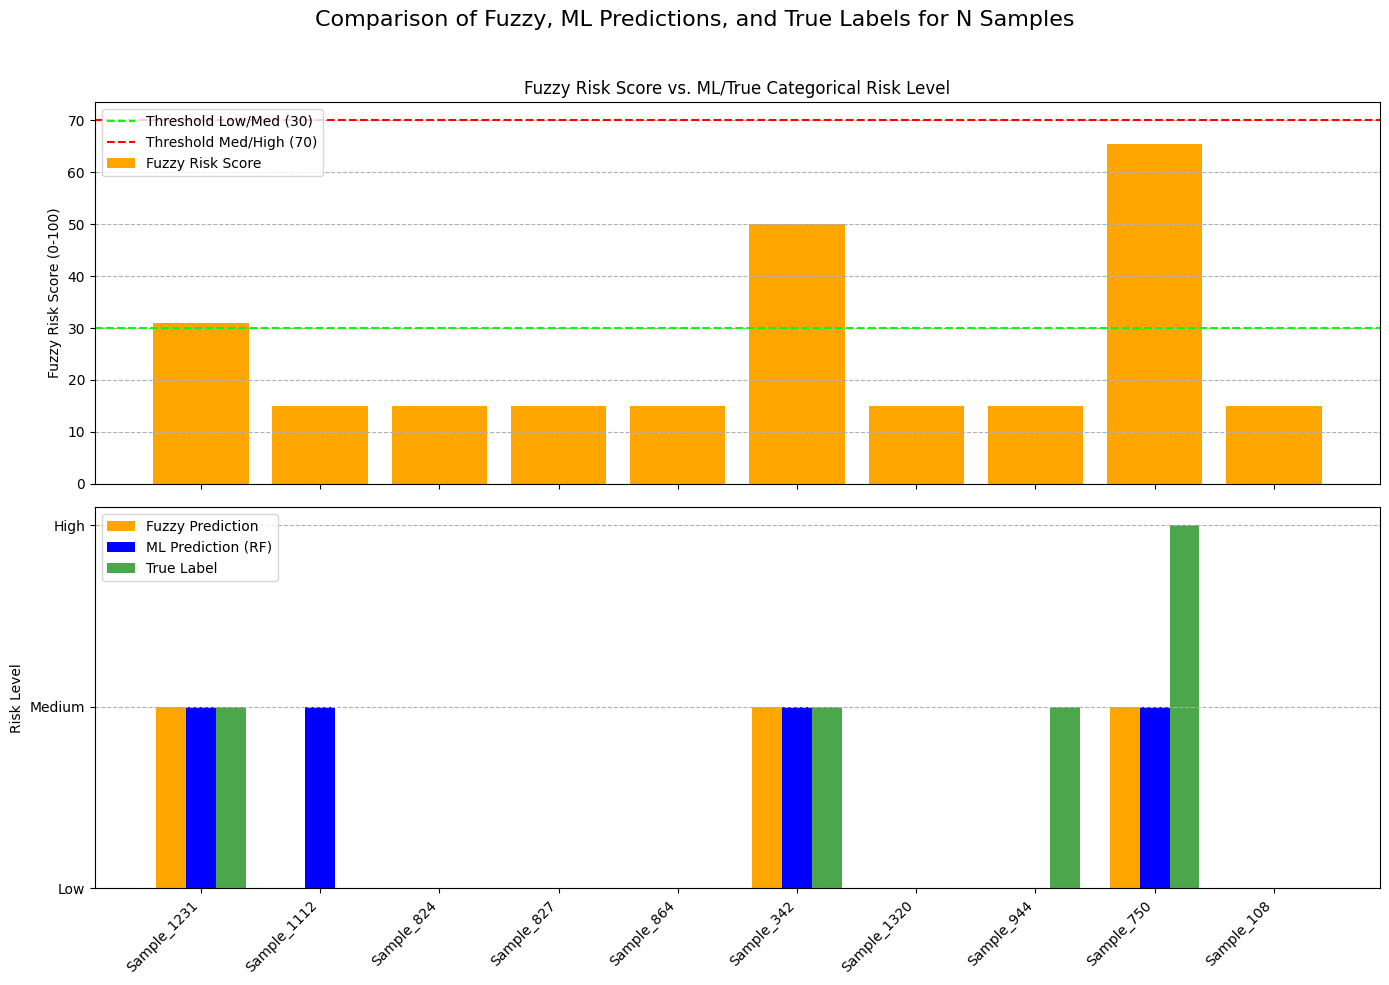

Sample Index | True Label | ML Pred  | Fuzzy Pred | Fuzzy Score | True_Num | ML_Num | Fuzzy_Num
------------------------------------------------------------------------------------------
1231         | Medium     | Medium   | Medium     |      31.03 | 1        | 1      | 1        
1112         | Low        | Medium   | Low        |      15.00 | 0        | 1      | 0        
824          | Low        | Low      | Low        |      15.00 | 0        | 0      | 0        
827          | Low        | Low      | Low        |      15.00 | 0        | 0      | 0        
864          | Low        | Low      | Low        |      15.00 | 0        | 0      | 0        
342          | Medium     | Medium   | Medium     |      50.00 | 1        | 1      | 1        
1320         | Low        | Low      | Low        |      15.00 | 0        | 0      | 0        
944          | Medium     | Low      | Low        |      15.00 | 1        | 0      | 0        
750          | High       | Medium   | Medium     |  

In [16]:
N = 10
if len(X_test) >= N:
    sample_indices = np.random.choice(X_test.index, size=N, replace=False)
else:
    print(f"Warning: X_test has only {len(X_test)} samples. Using all of them for plotting.")
    sample_indices = X_test.index
    N = len(X_test)

sample_features_for_fuzzy = df.loc[sample_indices][['Age', 'MonthlyIncome', 'JobLevel']].copy()
sample_features_for_ml = X_test.loc[sample_indices].copy()

true_labels_cat_plot = y_test.loc[sample_indices].values
ml_predictions_cat_plot = clf.predict(sample_features_for_ml)

fuzzy_predictions_list_plot = []

for _, row in sample_features_for_fuzzy.iterrows():
    try:
        access_risk_sim_fuzzy.input['Age'] = row['Age']
        access_risk_sim_fuzzy.input['Income'] = row['MonthlyIncome']
        access_risk_sim_fuzzy.input['JobLevel'] = row['JobLevel']
        access_risk_sim_fuzzy.compute()
        fuzzy_score_plot = access_risk_sim_fuzzy.output['AccessRisk_Fuzzy']

        if fuzzy_score_plot < 30: # Thresholds from Gradio
            fuzzy_pred_label_cat_plot = "Low"
        elif fuzzy_score_plot < 70:
            fuzzy_pred_label_cat_plot = "Medium"
        else:
            fuzzy_pred_label_cat_plot = "High"
        fuzzy_predictions_list_plot.append((fuzzy_score_plot, fuzzy_pred_label_cat_plot))
    except Exception as e:
        fuzzy_predictions_list_plot.append((np.nan, "Error"))

fuzzy_scores_plot = [score for score, _ in fuzzy_predictions_list_plot]
fuzzy_labels_cat_plot = [label for _, label in fuzzy_predictions_list_plot]

label_map_plot = {"Low": 0, "Medium": 1, "High": 2, "Error": -1}
true_labels_num_plot = np.array([label_map_plot.get(lbl, -1) for lbl in true_labels_cat_plot])
ml_predictions_num_plot = np.array([label_map_plot.get(lbl, -1) for lbl in ml_predictions_cat_plot])
fuzzy_labels_num_plot = np.array([label_map_plot.get(lbl, -1) for lbl in fuzzy_labels_cat_plot])

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
axs[0].bar(range(N), fuzzy_scores_plot, color='orange', label='Fuzzy Risk Score')
axs[0].set_ylabel("Fuzzy Risk Score (0-100)")
axs[0].set_title("Fuzzy Risk Score vs. ML/True Categorical Risk Level")
axs[0].axhline(30, color='lime', linestyle='--', label='Threshold Low/Med (30)')
axs[0].axhline(70, color='red', linestyle='--', label='Threshold Med/High (70)')
axs[0].legend()
axs[0].grid(True, axis='y', linestyle='--')

x_plot_labels_val = [f"Sample_{idx}" for idx in sample_indices]
x_positions_plot = np.arange(N)
bar_width_plot = 0.25
axs[1].bar(x_positions_plot - bar_width_plot, fuzzy_labels_num_plot, width=bar_width_plot, label='Fuzzy Prediction', color='orange', align='center')
axs[1].bar(x_positions_plot, ml_predictions_num_plot, width=bar_width_plot, label='ML Prediction (RF)', color='blue', align='center')
axs[1].bar(x_positions_plot + bar_width_plot, true_labels_num_plot, width=bar_width_plot, label='True Label', color='green', align='center', alpha=0.7)
axs[1].set_xticks(x_positions_plot)
axs[1].set_xticklabels(x_plot_labels_val, rotation=45, ha="right")
axs[1].set_ylabel("Risk Level")
axs[1].set_yticks([0, 1, 2])
axs[1].set_yticklabels(["Low", "Medium", "High"])
axs[1].legend(loc='upper left')
axs[1].grid(True, axis='y', linestyle='--')

plt.suptitle("Comparison of Fuzzy, ML Predictions, and True Labels for N Samples", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("Sample Index | True Label | ML Pred  | Fuzzy Pred | Fuzzy Score | True_Num | ML_Num | Fuzzy_Num")
print("-" * 90)
for i in range(N):
    print(f"{sample_indices[i]:<12} | {true_labels_cat_plot[i]:<10} | {ml_predictions_cat_plot[i]:<8} | {fuzzy_labels_cat_plot[i]:<10} | {fuzzy_scores_plot[i]:>10.2f} | "
          f"{true_labels_num_plot[i]:<8} | {ml_predictions_num_plot[i]:<6} | {fuzzy_labels_num_plot[i]:<9}")

## 5. Gradio Interface for Fuzzy Logic Predictor

In [ ]:
def predict_access_risk_gradio(age_input, income_input, job_level_input):
    try:
        access_risk_sim_fuzzy.input['Age'] = age_input
        access_risk_sim_fuzzy.input['Income'] = income_input
        access_risk_sim_fuzzy.input['JobLevel'] = job_level_input

        access_risk_sim_fuzzy.compute()

        risk_score = access_risk_sim_fuzzy.output['AccessRisk_Fuzzy']

        if risk_score < 30: # Based on fuzzy output MFs or desired thresholds
            label = "Low"
        elif risk_score < 70:
            label = "Medium"
        else:
            label = "High"

        return f"Risk Score: {risk_score:.2f}", f"Risk Level: {label}"

    except Exception as e:
        return "Error", f"Exception: {str(e)}"

# Gradio Interface
gr.Interface(
    fn=predict_access_risk_gradio,
    inputs=[
        gr.Slider(18, 60, value=30, label="Age (18-60)"), # Matches age_fuzzy.universe
        gr.Slider(df['MonthlyIncome'].min(), df['MonthlyIncome'].max(), step=100, value=df['MonthlyIncome'].median(), label=f"Income ({df['MonthlyIncome'].min()}-{df['MonthlyIncome'].max()})"), # Matches income_fuzzy.universe
        gr.Slider(1, 5, step=1, value=2, label="Job Level (1-5)") # Matches job_level_fuzzy.universe
    ],
    outputs=[
        gr.Textbox(label="Fuzzy Risk Score"),
        gr.Textbox(label="Fuzzy Risk Level")
    ],
    title="IAM Fuzzy Logic Access Risk Predictor",
    description="Adjust the inputs to see how fuzzy logic determines access risk"
).launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e6d729d85777d76627.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
